In [2]:
!pip install sliderule

  Using cached sliderule-1.4.4-py3-none-any.whl (75 kB)


In [3]:
# standard imports
import datetime
import pandas as pd

import os
import dask
from dask.diagnostics import ProgressBar
import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import logging
import panel as pn
pn.extension()
import matplotlib.lines
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import shapely.geometry
import warnings
# grimp and nisar functions
# import grimpfunc as grimp
# import nisardev as nisar
# sliderule functions
import sliderule
import sliderule.icesat2
import sliderule.io
import sliderule.ipysliderule

import pickle

import glob

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas

# import this to use define sql functions (e.g. postgis!)
from sqlalchemy.sql import func 

# Import this to convert to a rasterio object for easy plotting
from snowexsql.conversions import raster_to_rasterio 

# Import a convenient function to plot with 
import rasterio
from rasterio.plot import show

# register progress bar and set workers
ProgressBar().register()
dask.config.set(num_workers=2)
# turn off warnings for demo
warnings.filterwarnings('ignore')

## Pickle import boundary of Grand Mesa

In [59]:
# Polygon of Grand Mesa boundary
out_fp = "../../data/bounds.pkl"
polygon = pickle.load(open(out_fp, 'rb'))

poly_gdf = gpd.GeoDataFrame(polygon['Grand Mesa, CO'], index = [0], columns = ['geometry'], crs='epsg:4326')

## Rasterio import ASO DEM tif file

In [60]:
file = "../../data/ASO_3M_PCDTM_USCOGM_20160926_20160926.tif"

In [61]:
# resample 3 x 3 m image into 20 x 20 image
# !gdal_translate  -tr 20, 20 ./ASO_3M_PCDTM_USCOGM_20160926_20160926.tif ./ASO_3M_PCDTM_USCOGM_20160926_20160926_resample.tif

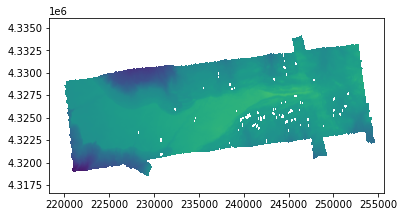

<AxesSubplot:>

In [62]:
src = rasterio.open(file)
array = src.read(1)
trsform = src.transform
lon, lat = trsform * (0,0)
show(src, vmin = 2000, vmax = 4000)

## Sliderule: Import ICESAt-2 data for this region

In [63]:
# set the url for the sliderule service
# set the logging level
sliderule.icesat2.init("icesat2sliderule.org", loglevel=logging.WARNING)

In [64]:
# display widgets for setting SlideRule parameters
SRwidgets = sliderule.ipysliderule.widgets()
# show widgets
widgets.VBox([
    SRwidgets.asset,
    SRwidgets.release,
    SRwidgets.surface_type,
    SRwidgets.length,
    SRwidgets.step,
    SRwidgets.confidence,
    SRwidgets.land_class,
    SRwidgets.iteration,
    SRwidgets.spread,
    SRwidgets.count,
    SRwidgets.window,
    SRwidgets.sigma,
])

In [65]:
widgets.VBox([SRwidgets.projection, SRwidgets.layers])

In [106]:
# create ipyleaflet map in specified projection
m = sliderule.ipysliderule.leaflet(SRwidgets.projection.value)
m.map

# sliderule asset and data release
asset = SRwidgets.asset.value
release = SRwidgets.release.value

# build sliderule parameters using latest values from widget
params = {
    # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
    "srt": SRwidgets.surface_type.index,
    # length of ATL06-SR segment in meters
    "len": SRwidgets.length.value,
    # step distance for successive ATL06-SR segments in meters
    "res": SRwidgets.step.value,
    # confidence level for PE selection
    "cnf": SRwidgets.confidence.value,
    # ATL08 land surface classifications
    "atl08_class": list(SRwidgets.land_class.value),
    # maximum iterations, not including initial least-squares-fit selection
    "maxi": SRwidgets.iteration.value,
    # minimum along track spread
    "ats": SRwidgets.spread.value,
    # minimum PE count
    "cnt": SRwidgets.count.value,
    # minimum height of PE window in meters
    "H_min_win": SRwidgets.window.value,
    # maximum robust dispersion in meters
    "sigma_r_max": SRwidgets.sigma.value
}

# Region of interest
region = sliderule.icesat2.toregion(poly_gdf)

# params["t0"] = '2020-01-01T00:00:00Z' # Start date
# params["t1"] = '2020-03-31T00:00:00Z' # End date

# create an empty geodataframe
gdf = sliderule.icesat2.__emptyframe()
# for each region of interest

params["poly"] = region["poly"]   # will always be the convex hull of the polygon
params["raster"] = region["raster"]   # raster will include all vertices, including holes. This is more processing, but is only an issue with very large requests.
gdf = sliderule.icesat2.atl06p(params, asset, version=release)

gdf = gdf.reset_index()
gdf = gdf.rename(columns ={'index':'time'})

print("ATL08 data is loaded! ", len(gdf))


ERROR:sliderule.sliderule:Server experiencing heavy load, stalling on request to http://54.213.230.113/source/atl06 ... will retry
ERROR:sliderule.sliderule:Server experiencing heavy load, stalling on request to http://54.213.230.113/source/atl06 ... will retry
ERROR:sliderule.sliderule:Server experiencing heavy load, stalling on request to http://34.216.40.187/source/atl06 ... will retry
ERROR:sliderule.sliderule:Server experiencing heavy load, stalling on request to http://34.216.40.187/source/atl06 ... will retry
ERROR:sliderule.sliderule:Server experiencing heavy load, stalling on request to http://54.213.230.113/source/atl06 ... will retry
ERROR:sliderule.sliderule:Server experiencing heavy load, stalling on request to http://54.213.230.113/source/atl06 ... will retry
ERROR:sliderule.sliderule:Server experiencing heavy load, stalling on request to http://54.213.230.113/source/atl06 ... will retry
ERROR:sliderule.sliderule:Server experiencing heavy load, stalling on request to http

ATL08 data is loaded!  15226


In [97]:
# Process gdf file: add temporal and spatial information
for i in range(0, len(gdf)):
    # gdf.loc[i, "date"] = gdf["time"][i].date()
    gdf.loc[i, "year"] = gdf["time"][i].year
    gdf.loc[i, "month"] = gdf["time"][i].month
    gdf.loc[i, "day"] = gdf["time"][i].day
    gdf.loc[i, "lat"] = gdf["geometry"][i].y
    gdf.loc[i, "lon"] = gdf["geometry"][i].x

## Calculate snow depth combining ATL08 & ASO DEM

In [102]:
# Sample ASO DEM with ATL08 geodataframe
def sample_raster(df, src, diff_col=None):
    #df_proj = df.to_crs(src.crs)
    coord = [(pt.x, pt.y) for pt in df.to_crs(src.crs).geometry]
    s = np.fromiter(src.sample(coord), dtype=src.dtypes[0])
    #s[s == src.nodata] = np.nan
    sm = np.ma.masked_equal(s, src.nodata)
    sm[sm <= 0] = np.nan
    sample_colname = os.path.splitext(os.path.split(src.name)[-1])[0]
    df[sample_colname] = sm
    if diff_col is not None:
        out_colname = 'diff'
        df[out_colname] = df[diff_col] - df[sample_colname]
        return df
    else:
        out_colname = sample_colname
        return out_colname

In [103]:
gdf2 = sample_raster(gdf, src, "h_mean")

# Remove invalid data points
gdf2 = gdf2[gdf2["diff"] >= -9999].reset_index(drop = True)

In [105]:
gdf2

time       h_mean  rms_misfit    delta_time  \
0    2018-11-15 21:07:35.507301452  2980.594716    0.141154  2.755126e+07   
1    2018-11-15 21:07:35.510113648  2980.577977    0.163428  2.755126e+07   
2    2018-11-15 21:07:35.512926608  2980.610419    0.141337  2.755126e+07   
3    2018-11-15 21:07:35.515740568  2980.507371    0.118160  2.755126e+07   
4    2018-11-15 21:07:35.529740244  3177.852452    0.226768  2.755126e+07   
...                            ...          ...         ...           ...   
8322 2021-10-11 18:29:17.427525840  3023.789414    0.133477  1.192122e+08   
8323 2021-10-11 18:29:17.430333712  3023.981802    0.130105  1.192122e+08   
8324 2021-10-11 18:29:17.433136672  3024.015589    0.119050  1.192122e+08   
8325 2021-10-11 18:29:17.435932288  3023.836184    0.111830  1.192122e+08   
8326 2021-10-11 18:29:17.438726656  3023.612264    0.070316  1.192122e+08   

       h_sigma  rgt  n_fit_photons  pflags  dh_fit_dx  spot  ...  dh_fit_dy  \
0     0.025316  737             34       0   0.009144     6  ...        0.0   
1     0.043345  737             20       0  -0.002196     6  ...        0.0   
2     0.029030  737             38       0  -0.000247     6  ...        0.0   
3     0.019512  737             47       0  -0.013711     6  ...        0.0   
4     0.050629  737             43       0   0.093705     4  ...        0.0   
...        ...  ...            ...     ...        ...   ...  ...        ...   
8322  0.023168  295             41       0   0.016153     5  ...        0.0   
8323  0.016392  295             63       0   0.006967     5  ...        0.0   
8324  0.015732  295             58       0  -0.005582     5  ...        0.0   
8325  0.021721  295             34       0  -0.013707     5  ...        0.0   
8326  0.042294  295             11       0  -0.011036     5  ...        0.0   

          distance                     geometry    year  month   day  \
0     4.338665e+06  POINT (-108.11390 38.99189)  2018.0   11.0  15.0   
1     4.338685e+06  POINT (-108.11392 38.99207)  2018.0   11.0  15.0   
2     4.338705e+06  POINT (-108.11394 38.99225)  2018.0   11.0  15.0   
3     4.338725e+06  POINT (-108.11396 38.99243)  2018.0   11.0  15.0   
4     4.338926e+06  POINT (-108.07763 38.99696)  2018.0   11.0  15.0   
...            ...                          ...     ...    ...   ...   
8322  4.344961e+06  POINT (-108.22235 39.06008)  2021.0   10.0  11.0   
8323  4.344981e+06  POINT (-108.22237 39.06026)  2021.0   10.0  11.0   
8324  4.345001e+06  POINT (-108.22239 39.06044)  2021.0   10.0  11.0   
8325  4.345021e+06  POINT (-108.22242 39.06062)  2021.0   10.0  11.0   
8326  4.345041e+06  POINT (-108.22244 39.06080)  2021.0   10.0  11.0   

            lat         lon  ASO_3M_PCDTM_USCOGM_20160926_20160926      diff  
0     38.991887 -108.113899                            2980.455078  0.139638  
1     38.992066 -108.113920                            2980.770020 -0.192042  
2     38.992246 -108.113942                            2980.858887 -0.248467  
3     38.992426 -108.113964                            2980.304932  0.202440  
4     38.996958 -108.077627                            3179.382080 -1.529628  
...         ...         ...                                    ...       ...  
8322  39.060077 -108.222353                            3023.825928 -0.036513  
8323  39.060257 -108.222374                            3024.128906 -0.147104  
8324  39.060436 -108.222394                            3024.128906 -0.113317  
8325  39.060616 -108.222415                            3023.791992  0.044192  
8326  39.060796 -108.222436                            3023.110107  0.502157  

[8327 rows x 24 columns]

## Visualize snow depth (elevation difference)

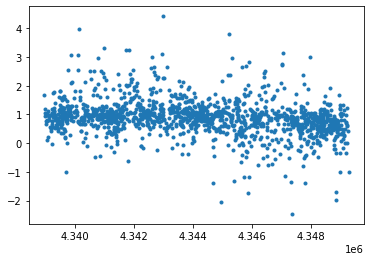

In [89]:
# Draw profile of elevation difference (snow depth)
idx = (gdf2["day"] == gdf2["day"].unique()[0])
plt.plot(gdf2["distance"][idx], gdf2['diff'][idx], '.')

In [90]:
# Draw map of elevation differences
m.GeoData(gdf2, column_name="diff", cmap=SRwidgets.colormap,
    max_plot_points=10000, tooltip=True, colorbar=True)

m.map

Map(center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Compare snow depth measurement at Grand Mesa 

In [4]:
# database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas
from sqlalchemy.sql import func 

In [5]:
# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
engine, session = get_db(db_name)

print('SnowEx Database successfully loaded!')

SnowEx Database successfully loaded!


In [6]:
print(session.query(ImageData.type).distinct().all())

[('swe',), ('DEM',), ('insar amplitude',), ('insar correlation',), ('depth',), ('insar interferogram real',), ('insar interferogram imaginary',)]


In [7]:
# Query the session using .observers() to generate a list
qry = session.query(ImageData.observers)

# Locate all that are distinct
airborne_sensors_list = session.query(ImageData.observers).distinct().all()

print('list of airborne sensors by "observer" name: \n', airborne_sensors_list)

list of airborne sensors by "observer" name: 
 [('USGS',), ('UAVSAR team, JPL',), ('ASO Inc.',)]


In [8]:
session.close()

In [9]:
engine, session = get_db(db_name)

# Remember in the query parentheses is what we get back, in this case were asking for the raster data as a geotiff
qry = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.type == 'depth')

qry = qry.filter(ImageData.site_name == "Grand Mesa")

# Grab the unique dates
qry = qry.distinct().all()

# # Now make it more available as a python object 
# datasets = raster_to_rasterio(session, qry)

# # Plot the georeferenced image 
# show(datasets[0], vmax=1.2, vmin=0, cmap='winter')

# # Close the dataset
# datasets[0].close()
# session.close()

In [10]:
from datetime import date

# Pick a dataset
dataset = 'depth'

# Pick a date
collection_date = date(2020, 2, 7)

# Site name
site_name = "Grand Mesa"

# Get a session
engine, session = get_db(db_name)

# The part inside the query function is what we want back, in this case all columns for the point data
qry = session.query(PointData)

# Filter by site
qry = qry.filter(PointData.site_name == site_name)

# We then want to filter by the selected the data type depth.
qry = qry.filter(PointData.type == dataset)

# Filter by instrument
qry = qry.filter(PointData.instrument == 'magnaprobe')

# Filter by a date
# qry = qry.filter(PointData.date == collection_date)

# Limit it to a couple hundred - just for exploration
qry = qry.limit(100000)

# Execute the query and convert to geopandas in one handy function
df = query_to_geopandas(qry, engine)

session.close()

In [11]:
df['date'].unique()

array([datetime.date(2020, 1, 28), datetime.date(2020, 1, 29),
       datetime.date(2020, 1, 30), datetime.date(2020, 1, 31),
       datetime.date(2020, 2, 1), datetime.date(2020, 2, 4),
       datetime.date(2020, 2, 5), datetime.date(2020, 2, 6),
       datetime.date(2020, 2, 7), datetime.date(2020, 2, 8),
       datetime.date(2020, 2, 10), datetime.date(2020, 2, 11),
       datetime.date(2020, 2, 12)], dtype=object)

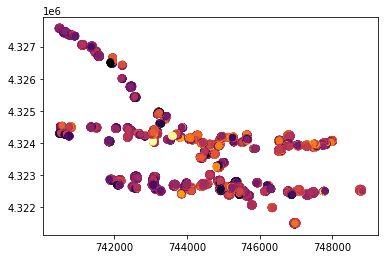

In [93]:
plt.scatter(df["easting"], df["northing"], c = df["value"], vmin = 50, vmax = 150, cmap = "inferno")

In [77]:
gdf2.keys()

Index(['time', 'h_mean', 'rms_misfit', 'delta_time', 'h_sigma', 'rgt',
       'n_fit_photons', 'pflags', 'dh_fit_dx', 'spot',
       'w_surface_window_final', 'gt', 'segment_id', 'cycle', 'dh_fit_dy',
       'distance', 'geometry', 'year', 'month', 'day', 'lat', 'lon',
       'ASO_3M_PCDTM_USCOGM_20160926_20160926', 'diff'],
      dtype='object')

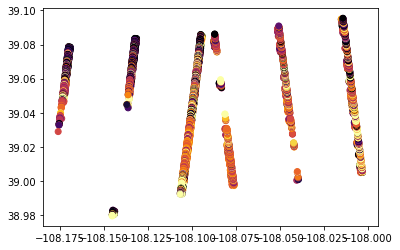

In [91]:
plt.scatter(gdf2["lon"], gdf2["lat"], c = gdf2["diff"]*100, vmin = 0, vmax = 150, cmap = "inferno")

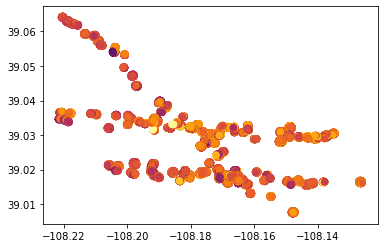

In [94]:
plt.scatter(df["longitude"], df["latitude"], c = df["value"], vmin = 0, vmax = 150, cmap = "inferno")

## Compare snow-free days v. snow-on days

In [400]:
# Polygon of Grand Mesa boundary
out_fp = "../../data/IS2_snow_depth.pkl"
gdf3 = pickle.load(open(out_fp, 'rb'))
gdf3 = gdf3[abs(gdf3["diff"]) < 20]
gdf3["snow_presence"] = gdf3["snow_presence"].astype(float)
gdf3.head(3)

time       h_mean  \
time                                                                       
2018-11-15 21:07:35.507301452 2018-11-15 21:07:35.507301452  2980.594716   
2018-11-15 21:07:35.510113648 2018-11-15 21:07:35.510113648  2980.577977   
2018-11-15 21:07:35.512926608 2018-11-15 21:07:35.512926608  2980.610419   

                               rms_misfit    delta_time   h_sigma  rgt  \
time                                                                     
2018-11-15 21:07:35.507301452    0.141154  2.755126e+07  0.025316  737   
2018-11-15 21:07:35.510113648    0.163428  2.755126e+07  0.043345  737   
2018-11-15 21:07:35.512926608    0.141337  2.755126e+07  0.029030  737   

                               n_fit_photons  pflags  dh_fit_dx  spot  ...  \
time                                                                   ...   
2018-11-15 21:07:35.507301452             34       0   0.009144     6  ...   
2018-11-15 21:07:35.510113648             20       0  -0.002196     6  ...   
2018-11-15 21:07:35.512926608             38       0  -0.000247     6  ...   

                                day        lat         lon   lidar_elev  \
time                                                                      
2018-11-15 21:07:35.507301452  15.0  38.991887 -108.113899  2980.455078   
2018-11-15 21:07:35.510113648  15.0  38.992066 -108.113920  2980.770020   
2018-11-15 21:07:35.512926608  15.0  38.992246 -108.113942  2980.858887   

                                   diff  doy      decyear  dowy  \
time                                                              
2018-11-15 21:07:35.507301452  0.139638  319  2018.873645    46   
2018-11-15 21:07:35.510113648 -0.192042  319  2018.873645    46   
2018-11-15 21:07:35.512926608 -0.248467  319  2018.873645    46   

                               snow_presence  diff_corr  
time                                                     
2018-11-15 21:07:35.507301452            1.0   0.094005  
2018-11-15 21:07:35.510113648            1.0  -0.237674  
2018-11-15 21:07:35.512926608            1.0  -0.294099  

[3 rows x 29 columns]

In [402]:
# Polygon of Grand Mesa boundary
out_fp = "../../data/snotel_depths.pkl"
snotel = pickle.load(open(out_fp, 'rb'))
snotel = snotel.reset_index()

snotel["Time"] = pd.to_datetime(snotel["Date"], format='%Y-%m-%d')
snotel.index = snotel["Time"]

In [403]:
gdf_off = gdf3[gdf3["snow_presence"] == 0]
gdf_on = gdf3[gdf3["snow_presence"] == 1]

(-20.0, 20.0)

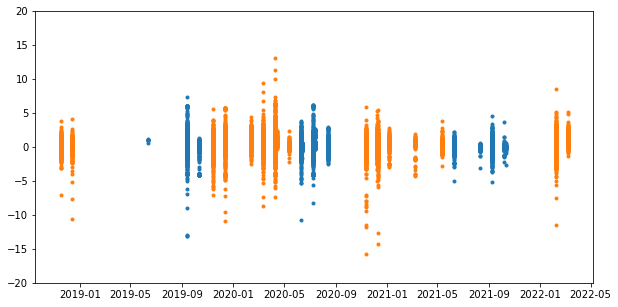

In [404]:
plt.figure(figsize = (10, 5))
plt.plot(gdf_off["diff"], '.')
plt.plot(gdf_on["diff"], '.')
plt.ylim(-20, 20)

In [405]:
gdf_mean = gdf3.groupby(["year", "doy"], as_index = False).median()
gdf_mean["diff_std"] = gdf3.groupby(["year", "doy"], as_index = False).std()["diff"]
gdf_mean.index = gdf3.groupby(["year", "doy"], as_index = False).first()["time"]

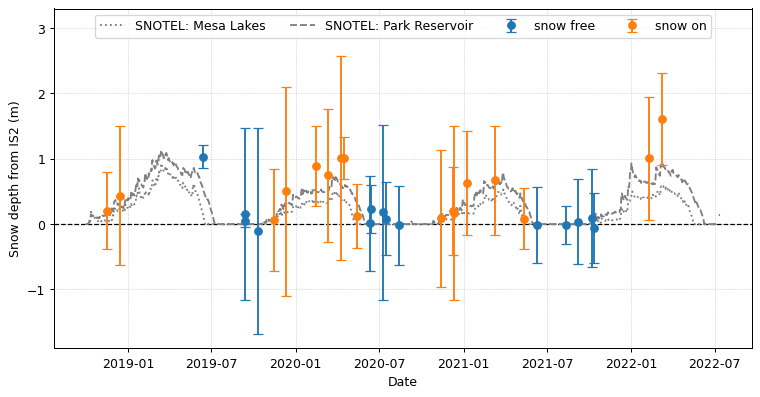

In [406]:
plt.figure(figsize = (10, 5), dpi = 90)
plt.axhline(0, c = "k", ls = "--", lw = 1)

plt.plot(snotel["MesaLakes"]*0.01, label = "SNOTEL: Mesa Lakes", color = "gray", ls = ":")
plt.plot(snotel["ParkReservoir"]*0.01, label = "SNOTEL: Park Reservoir", color = "gray", ls = "--")

labels = ["snow free", "snow on"]
for s in [0, 1]:
    idx = (gdf_mean["snow_presence"] == s)
    # plt.plot(gdf_mean["diff"][idx], 'o')
    # plt.bar(gdf_mean.index[idx], gdf_mean["diff"][idx], yerr=gdf_mean["diff_std"][idx])
    plt.errorbar(gdf_mean.index[idx], gdf_mean["diff"][idx], yerr=gdf_mean["diff_std"][idx],
                 label = labels[s], marker="o", markersize = 6, linestyle="none", capsize = 4)


plt.xlabel("Date")
plt.ylabel("Snow depth from IS2 (m)")
plt.grid(ls = ":", lw = 0.5)
plt.legend(ncol = 4, loc = "upper center")
plt.ylim(-1.9, 3.3)
plt.show()

In [407]:
t1 = datetime.datetime(2020, 1, 1)
t2 = datetime.datetime(2020, 3, 30)
t_win = (gdf3.index >= t1) & (gdf3.index <= t2)
gdf4 = gdf3[t_win]

gdf4.head(3)

time       h_mean  \
time                                                                       
2020-02-12 23:26:20.887750216 2020-02-12 23:26:20.887750216  3027.211171   
2020-02-12 23:26:20.898124544 2020-02-12 23:26:20.898124544  3182.068258   
2020-02-12 23:26:20.899715792 2020-02-12 23:26:20.899715792  2991.773452   

                               rms_misfit    delta_time   h_sigma  rgt  \
time                                                                     
2020-02-12 23:26:20.887750216    0.116278  6.678518e+07  0.017354  737   
2020-02-12 23:26:20.898124544    0.173172  6.678518e+07  0.026657  737   
2020-02-12 23:26:20.899715792    0.174062  6.678518e+07  0.017668  737   

                               n_fit_photons  pflags  dh_fit_dx  spot  ...  \
time                                                                   ...   
2020-02-12 23:26:20.887750216             74       0  -0.002138     4  ...   
2020-02-12 23:26:20.898124544             54       0  -0.007607     6  ...   
2020-02-12 23:26:20.899715792             98       0   0.003854     2  ...   

                                day        lat         lon   lidar_elev  \
time                                                                      
2020-02-12 23:26:20.887750216  12.0  39.000441 -108.040610  3026.541260   
2020-02-12 23:26:20.898124544  12.0  38.997354 -108.077182  3181.118896   
2020-02-12 23:26:20.899715792  12.0  39.004951 -108.004246  2991.012939   

                                   diff  doy      decyear  dowy  \
time                                                              
2020-02-12 23:26:20.887750216  0.669912   43  2020.117422   135   
2020-02-12 23:26:20.898124544  0.949362   43  2020.117422   135   
2020-02-12 23:26:20.899715792  0.760513   43  2020.117422   135   

                               snow_presence  diff_corr  
time                                                     
2020-02-12 23:26:20.887750216            1.0   0.624280  
2020-02-12 23:26:20.898124544            1.0   0.903730  
2020-02-12 23:26:20.899715792            1.0   0.714881  

[3 rows x 29 columns]

In [409]:
unique_dates = gdf3.groupby(["year", "doy"], as_index = False).first()[["year", "doy", "time", "snow_presence"]]

for i, p in enumerate(unique_dates["snow_presence"]):
    if i == 0:
        seq = 0
    else:
        if (p != unique_dates["snow_presence"][i-1]):
            seq += 1
    unique_dates.loc[i, "seq"] = seq
    
unique_dates.head(3)

year  doy                          time  snow_presence  seq
0  2018.0  319 2018-11-15 21:07:35.507301452            1.0  0.0
1  2018.0  347 2018-12-13 08:01:26.372018104            1.0  0.0
2  2019.0  163 2019-06-12 23:21:03.295344704            0.0  1.0

In [410]:
for i,k in enumerate(range(len(unique_dates))):
    
    idx = (gdf3["year"] == unique_dates.loc[i, "year"]) & (gdf3["doy"] == unique_dates.loc[i, "doy"])
    gdf3.loc[idx, "seq"] = unique_dates.loc[i, "seq"]
    
gdf3.tail(3)

time       h_mean  \
time                                                                       
2022-03-07 23:39:20.731628864 2022-03-07 23:39:20.731628864  3177.347620   
2022-03-07 23:39:20.734443568 2022-03-07 23:39:20.734443568  3177.272823   
2022-03-07 23:39:20.737259424 2022-03-07 23:39:20.737259424  3177.338975   

                               rms_misfit    delta_time   h_sigma   rgt  \
time                                                                      
2022-03-07 23:39:20.731628864    0.133648  1.319316e+08  0.021721  1156   
2022-03-07 23:39:20.734443568    0.127930  1.319316e+08  0.017406  1156   
2022-03-07 23:39:20.737259424    0.113893  1.319316e+08  0.018103  1156   

                               n_fit_photons  pflags  dh_fit_dx  spot  ...  \
time                                                                   ...   
2022-03-07 23:39:20.731628864             38       0  -0.003295     4  ...   
2022-03-07 23:39:20.734443568             56       0  -0.003190     4  ...   
2022-03-07 23:39:20.737259424             51       0   0.009797     4  ...   

                                     lat         lon   lidar_elev      diff  \
time                                                                          
2022-03-07 23:39:20.731628864  38.998653 -108.078055  3175.402100  1.945521   
2022-03-07 23:39:20.734443568  38.998473 -108.078077  3175.211914  2.060909   
2022-03-07 23:39:20.737259424  38.998293 -108.078098  3175.371094  1.967882   

                               doy      decyear dowy  snow_presence  \
time                                                                  
2022-03-07 23:39:20.731628864   66  2022.180783  158            1.0   
2022-03-07 23:39:20.734443568   66  2022.180783  158            1.0   
2022-03-07 23:39:20.737259424   66  2022.180783  158            1.0   

                               diff_corr  seq  
time                                           
2022-03-07 23:39:20.731628864   1.899889  6.0  
2022-03-07 23:39:20.734443568   2.015277  6.0  
2022-03-07 23:39:20.737259424   1.922250  6.0  

[3 rows x 30 columns]

0 0.0
1 1.0
2 2.0
3 3.0
4 4.0
5 5.0
6 6.0


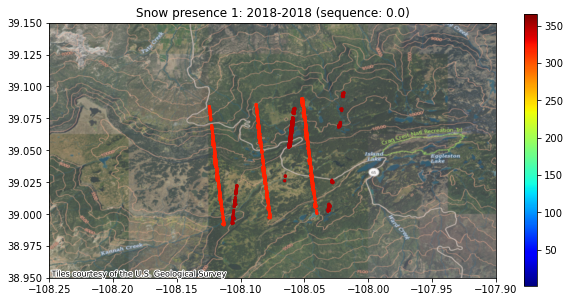

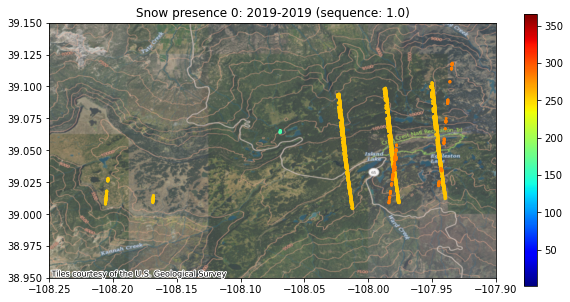

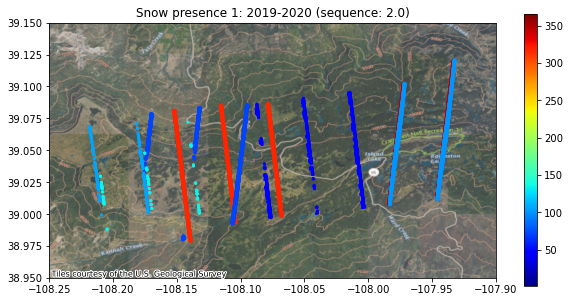

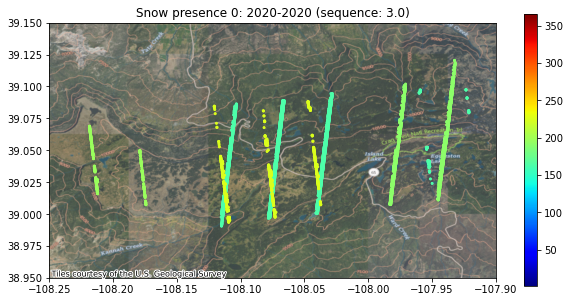

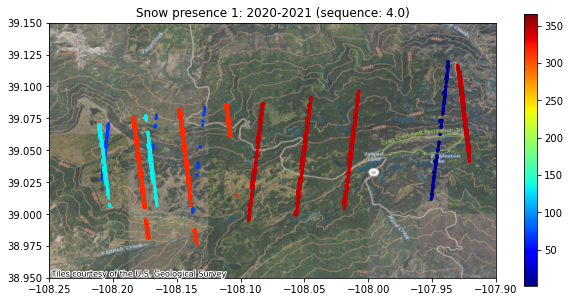

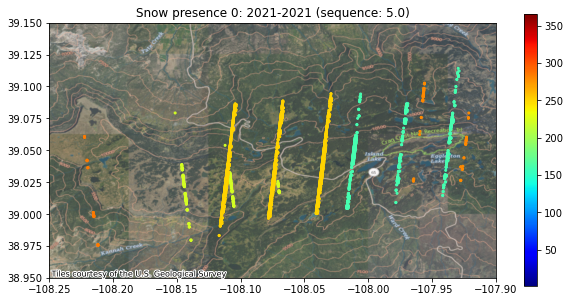

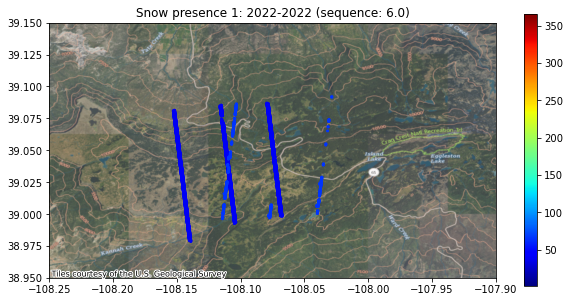

In [413]:
   
    
data_dir = '/tmp/uavsar-tutorial-data/'
img = rxa.open_rasterio(join(data_dir, f'cor.tif'))

for i,s in enumerate(np.unique(unique_dates["seq"])):
    
    fig, ax = plt.subplots(1, 1, figsize= (10, 5))
    
    print(i, s)
    subset = gdf3[gdf3["seq"] == s]
    # subset.plot(ax = ax, column = 'diff', legend = True, cmap = 'RdBu_r', vmin = -2, vmax = 2)
    subset.plot(ax = ax, column = 'doy', legend = True, markersize = 4, cmap = "jet", vmin = 1, vmax = 365)

    # Set same bounds as uavsar image plot
    ax.set_xlim(-108.25,-107.9)
    ax.set_ylim(38.95, 39.15)

    # Add background map
    # cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USTopo)
    cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USImageryTopo)
    ax.set_title("Snow presence {0}: {1}-{2} (sequence: {3})".format(int(subset.head(1)["snow_presence"].values[0]),
                                                    int(subset.head(1)["year"].values[0]),
                                                    int(subset.tail(1)["year"].values[0]),
                                                    s))

0 2


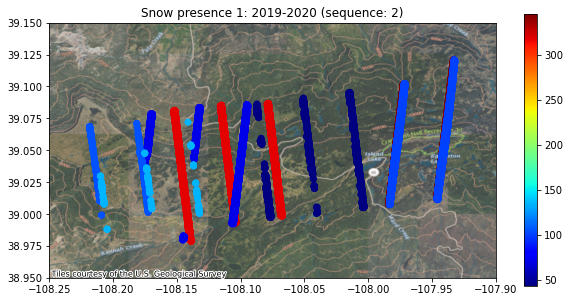

In [414]:
for i,s in enumerate([2]):
    
    fig, ax = plt.subplots(1, 1, figsize= (10,5))
    
    print(i, s)
    subset = gdf3[gdf3["seq"] == s]
    # subset.plot(ax = ax, column = 'diff', legend = True, cmap = 'RdBu_r', vmin = -2, vmax = 2)
    subset.plot(ax = ax, column = 'doy', legend = True, cmap = "jet")

    # Set same bounds as uavsar image plot
    ax.set_xlim(-108.25,-107.9)
    ax.set_ylim(38.95, 39.15)

    # Add background map
    # cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USTopo)
    cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USImageryTopo)
    ax.set_title("Snow presence {0}: {1}-{2} (sequence: {3})".format(int(subset.head(1)["snow_presence"].values[0]),
                                                    int(subset.head(1)["year"].values[0]),
                                                    int(subset.tail(1)["year"].values[0]),
                                                    s))

In [359]:
np.unique(subset["doy"])
# comparison pairs: (345, 100) - overlapped; (318, 71) - crossing

array([ 43,  71, 100, 105, 134, 318, 345])

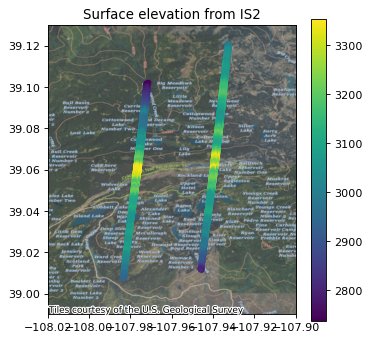

In [529]:
track1 = subset[subset["doy"] == 345]
track2 = subset[subset["doy"] == 100]

fig, ax = plt.subplots(1, 1, figsize= (5,5), dpi = 80)

track1.plot(ax = ax, column = 'h_mean', legend = True, cmap = "viridis", markersize = 10)
track2.plot(ax = ax, column = 'h_mean', cmap = "viridis", markersize = 10)

# Set same bounds as uavsar image plot
ax.set_xlim(-108.02,-107.9)
ax.set_ylim(38.99, 39.13)
ax.set_title("Surface elevation from IS2")

# Add background map
# cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USTopo)
cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USImageryTopo)

Snow depth first date:  0.6450575382595972
Snow depth first date:  1.115072889930695
Mean difference of snow depth: 0.4700 m


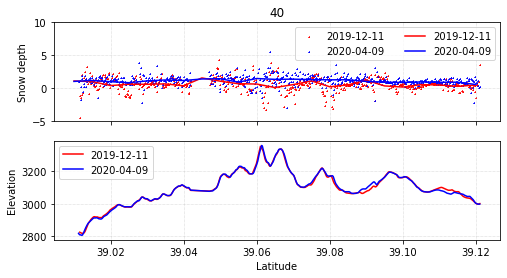

In [532]:
# Check overlapping tracks
def resample_is2(gdf, lat1, lat2, step, field = "diff"):
    lats = np.arange(lat1, lat2+step, step)
    output = np.zeros(len(lats))
    for i, L in enumerate(lats):
        value = gdf.loc[(gdf["lat"] >= L) & (gdf["lat"] <= L+step), field].median()
        output[i] = value
    return lats, output     

gt = 40 # 40, 60
xfield = "lat"
yfield = "diff"

fig, ax = plt.subplots(2, 1, figsize = (8, 4), sharex = True)
idx1 = (track1["gt"] == gt) & ((track1["lat"] > 39.047) | (track1["lat"] < 39.042))
idx2 = (track2["gt"] == gt) & ((track2["lat"] > 39.047) | (track2["lat"] < 39.042))
ax[0].scatter(track1[xfield][idx1], track1[yfield][idx1], s = 1, marker = "+", label = track1["time"][0].strftime("%Y-%m-%d"), color = "r")
ax[0].scatter(track2[xfield][idx2], track2[yfield][idx2], s = 1, marker = "+", label = track2["time"][0].strftime("%Y-%m-%d"), color = "b")

lats, res1 = resample_is2(track1[idx1], 39.0, 39.12, 0.005, field = "diff")
lats, res2 = resample_is2(track2[idx2], 39.0, 39.12, 0.005, field = "diff")

ax[0].plot(lats, res1, label = track1["time"][0].strftime("%Y-%m-%d"), color = "r")
ax[0].plot(lats, res2, label = track2["time"][0].strftime("%Y-%m-%d"), color = "b")

ax[0].grid(ls = ":", lw = 0.5)
ax[0].set_ylim(-5, 10)
ax[0].set_ylabel("Snow depth")
ax[0].legend(ncol = 2)
ax[0].set_title(gt)

print("Snow depth first date: ", np.nanmean(res1))
print("Snow depth first date: ", np.nanmean(res2))
print("Mean difference of snow depth: {0:.4f} m".format(np.nanmean(res2- res1)))

# Plot elevation =======================================
yfield = "h_mean"
ax[1].plot(track1[xfield][idx1], track1[yfield][idx1], label = track1["time"][0].strftime("%Y-%m-%d"), color = "r")
ax[1].plot(track2[xfield][idx2], track2[yfield][idx2], label = track2["time"][0].strftime("%Y-%m-%d"), color = "b")

ax[1].grid(ls = ":", lw = 0.5)
ax[1].legend()
ax[1].set_ylabel("Elevation")
ax[1].set_xlabel("Latitude")
plt.show()

Snow depth first date:  0.45624360335864367
Snow depth first date:  0.9342884515108267
Mean difference of snow depth: 0.4780 m


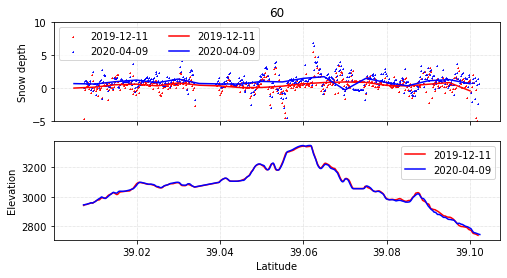

In [533]:
gt = 60 # 40, 60
xfield = "lat"
yfield = "diff"

fig, ax = plt.subplots(2, 1, figsize = (8, 4), sharex = True)
idx1 = (track1["gt"] == gt) & ((track1["lat"] > 39.039) | (track1["lat"] < 39.034))
idx2 = (track2["gt"] == gt) & ((track2["lat"] > 39.039) | (track2["lat"] < 39.034))
ax[0].scatter(track1[xfield][idx1], track1[yfield][idx1], s = 1, marker = "+", label = track1["time"][0].strftime("%Y-%m-%d"), color = "r")
ax[0].scatter(track2[xfield][idx2], track2[yfield][idx2], s = 1, marker = "+", label = track2["time"][0].strftime("%Y-%m-%d"), color = "b")

lats, res1 = resample_is2(track1[idx1], 39.0, 39.12, 0.005, field = "diff")
lats, res2 = resample_is2(track2[idx2], 39.0, 39.12, 0.005, field = "diff")

ax[0].plot(lats, res1, label = track1["time"][0].strftime("%Y-%m-%d"), color = "r")
ax[0].plot(lats, res2, label = track2["time"][0].strftime("%Y-%m-%d"), color = "b")

ax[0].grid(ls = ":", lw = 0.5)
ax[0].set_ylim(-5, 10)
ax[0].set_ylabel("Snow depth")
ax[0].legend(ncol = 2)
ax[0].set_title(gt)

print("Snow depth first date: ", np.nanmean(res1))
print("Snow depth first date: ", np.nanmean(res2))
print("Mean difference of snow depth: {0:.4f} m".format(np.nanmean(res2- res1)))

# Plot elevation =======================================
yfield = "h_mean"
ax[1].plot(track1[xfield][idx1], track1[yfield][idx1], label = track1["time"][0].strftime("%Y-%m-%d"), color = "r")
ax[1].plot(track2[xfield][idx2], track2[yfield][idx2], label = track2["time"][0].strftime("%Y-%m-%d"), color = "b")

ax[1].grid(ls = ":", lw = 0.5)
ax[1].legend()
ax[1].set_ylabel("Elevation")
ax[1].set_xlabel("Latitude")
plt.show()

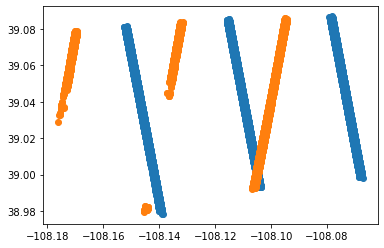

In [496]:
# Compare crossing tracks (318 & 71)
track1 = subset[subset["doy"] == 318]
track2 = subset[subset["doy"] == 71]

plt.scatter(track1["lon"], track1["lat"])
plt.scatter(track2["lon"], track2["lat"])

Snow depth difference:  1.4529613724172867


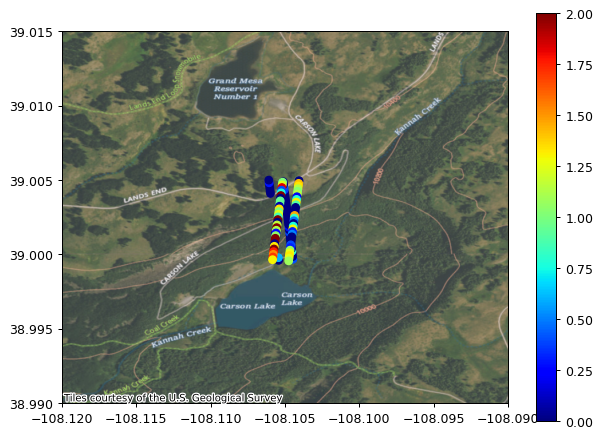

In [497]:
def area_snowdepth(track, bbox):
    sampled = track[(track["lon"] > bbox[0]) & (track["lon"] < bbox[2])]
    sampled = sampled[(sampled["lat"] > bbox[1]) & (sampled["lat"] < bbox[3])]
    return sampled

bbox = [-108.12, 38.9995, -108.10, 39.005]

sampled1 = area_snowdepth(track1, bbox)
sampled2 = area_snowdepth(track2, bbox)

sd1 = sampled1.mean()["diff"]
sd2 = sampled2.mean()["diff"]
print("Snow depth difference: ", sd2-sd1)

fig, ax = plt.subplots(1, 1, figsize= (8,6), dpi = 90)
    
sampled1.plot(ax = ax, column = 'diff', legend = True, cmap = "jet", vmin = 0, vmax = 2)
sampled2.plot(ax = ax, column = 'diff', cmap = "jet", vmin = 0, vmax = 2)

# Set same bounds as uavsar image plot
ax.set_xlim(-108.12,-108.09)
ax.set_ylim(38.99, 39.015)

# Add background map
# cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USTopo)
cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USImageryTopo)

In [528]:
print(snotel.loc[snotel.index == datetime.datetime(2019, 12, 1)])
print(snotel.loc[snotel.index == datetime.datetime(2020, 4, 9)])
# print(snotel.index[0], snotel.loc[snotel.index[44], "MesaLakes"])
# print(snotel.index[190], snotel.loc[snotel.index[190], "MesaLakes"])

                  Date  MesaLakes  ParkReservoir       Time
Time                                                       
2019-12-01  2019-12-01       16.0           30.0 2019-12-01
                  Date  MesaLakes  ParkReservoir       Time
Time                                                       
2020-04-09  2020-04-09       38.0           59.0 2020-04-09


In [389]:
out_fp = "../../data/grmesa_confidence.pkl"
test = pickle.load(open(out_fp, 'rb'))

In [390]:
test

n_fit_photons  dh_fit_dy   h_sigma  cycle  \
time                                                                       
2018-10-17 22:31:18.451049752             12        0.0  0.091676      1   
2018-10-17 22:31:18.458099976             18        0.0  0.048823      1   
2018-10-17 22:31:18.465141600             17        0.0  0.032050      1   
2018-10-17 22:31:18.472171260             10        0.0  0.106630      1   
2018-10-17 22:31:18.479208480             18        0.0  0.104997      1   
...                                      ...        ...       ...    ...   
2022-03-07 23:39:21.150983040             59        0.0  0.032379     14   
2022-03-07 23:39:21.158036960             52        0.0  0.040683     14   
2022-03-07 23:39:21.158716592             32        0.0  0.056379     14   
2022-03-07 23:39:21.165764304             82        0.0  0.017180     14   
2022-03-07 23:39:21.172804144             49        0.0  0.069807     14   

                               spot   rgt  segment_id  pflags  \
time                                                            
2018-10-17 22:31:18.451049752     2   295      216256       0   
2018-10-17 22:31:18.458099976     2   295      216258       0   
2018-10-17 22:31:18.465141600     2   295      216261       0   
2018-10-17 22:31:18.472171260     2   295      216263       0   
2018-10-17 22:31:18.479208480     2   295      216265       0   
...                             ...   ...         ...     ...   
2022-03-07 23:39:21.150983040     6  1156      785594       0   
2022-03-07 23:39:21.158036960     6  1156      785596       0   
2022-03-07 23:39:21.158716592     4  1156      785591       0   
2022-03-07 23:39:21.165764304     4  1156      785594       0   
2022-03-07 23:39:21.172804144     4  1156      785596       0   

                               w_surface_window_final  dh_fit_dx  \
time                                                               
2018-10-17 22:31:18.451049752                3.111202   0.025380   
2018-10-17 22:31:18.458099976                3.000000   0.021470   
2018-10-17 22:31:18.465141600                3.000000   0.027447   
2018-10-17 22:31:18.472171260                3.000000   0.025624   
2018-10-17 22:31:18.479208480                3.000000   0.049735   
...                                               ...        ...   
2022-03-07 23:39:21.150983040                3.000000   0.000827   
2022-03-07 23:39:21.158036960                3.000000  -0.000879   
2022-03-07 23:39:21.158716592                3.000000   0.007142   
2022-03-07 23:39:21.165764304                3.000000   0.002391   
2022-03-07 23:39:21.172804144                3.000000  -0.001207   

                                   distance       h_mean  rms_misfit  \
time                                                                   
2018-10-17 22:31:18.451049752  4.336883e+06  1774.852969    0.312240   
2018-10-17 22:31:18.458099976  4.336933e+06  1776.170553    0.205758   
2018-10-17 22:31:18.465141600  4.336983e+06  1777.465900    0.123890   
2018-10-17 22:31:18.472171260  4.337033e+06  1778.813468    0.336372   
2018-10-17 22:31:18.479208480  4.337083e+06  1780.784068    0.368985   
...                                     ...          ...         ...   
2022-03-07 23:39:21.150983040  1.573492e+07  3081.949503    0.153147   
2022-03-07 23:39:21.158036960  1.573497e+07  3081.936818    0.162212   
2022-03-07 23:39:21.158716592  1.573486e+07  3032.805862    0.136475   
2022-03-07 23:39:21.165764304  1.573491e+07  3033.058893    0.153115   
2022-03-07 23:39:21.172804144  1.573496e+07  3033.062682    0.149075   

                                 delta_time  gt                     geometry  \
time                                                                           
2018-10-17 22:31:18.451049752  2.505068e+07  50  POINT (-108.29836 38.98137)   
2018-10-17 22:31:18.458099976  2.505068e+07  50  POINT (-108.29841 38.98182)   
2018-10-17 22:31:18.465141600  2.505068e+07  50  POINT

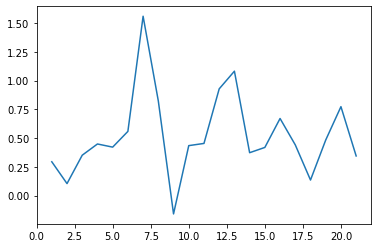

In [345]:
plt.plot(res2 - res1)

In [287]:
print(np.unique(track1["gt"]))
print(np.unique(track2["gt"]))

[30 40 50 60]
[30 40 50 60]


In [292]:
track1

time       h_mean  \
time                                                                       
2019-12-11 14:40:40.559739792 2019-12-11 14:40:40.559739792  3078.088775   
2019-12-11 14:40:40.562557320 2019-12-11 14:40:40.562557320  3080.824590   
2019-12-11 14:40:40.565375024 2019-12-11 14:40:40.565375024  3083.739153   
2019-12-11 14:40:40.568192888 2019-12-11 14:40:40.568192888  3087.406782   
2019-12-11 14:40:40.576644928 2019-12-11 14:40:40.576644928  3097.669233   
...                                                     ...          ...   
2019-12-11 14:40:42.450653408 2019-12-11 14:40:42.450653408  2948.252084   
2019-12-11 14:40:42.453445360 2019-12-11 14:40:42.453445360  2947.502246   
2019-12-11 14:40:42.456232688 2019-12-11 14:40:42.456232688  2947.244956   
2019-12-11 14:40:42.459020376 2019-12-11 14:40:42.459020376  2945.674321   
2019-12-11 14:40:42.461813664 2019-12-11 14:40:42.461813664  2940.888245   

                               rms_misfit    delta_time   h_sigma   rgt  \
time                                                                      
2019-12-11 14:40:40.559739792    0.318838  6.131044e+07  0.083455  1156   
2019-12-11 14:40:40.562557320    0.397028  6.131044e+07  0.087478  1156   
2019-12-11 14:40:40.565375024    0.345443  6.131044e+07  0.095344  1156   
2019-12-11 14:40:40.568192888    0.417440  6.131044e+07  0.100775  1156   
2019-12-11 14:40:40.576644928    0.507957  6.131044e+07  0.188878  1156   
...                                   ...           ...       ...   ...   
2019-12-11 14:40:42.450653408    0.404864  6.131044e+07  0.028697  1156   
2019-12-11 14:40:42.453445360    0.287683  6.131044e+07  0.022467  1156   
2019-12-11 14:40:42.456232688    0.348996  6.131044e+07  0.025964  1156   
2019-12-11 14:40:42.459020376    0.475400  6.131044e+07  0.034971  1156   
2019-12-11 14:40:42.461813664    0.448487  6.131044e+07  0.038877  1156   

                               n_fit_photons  pflags  dh_fit_dx  spot  ...  \
time                                                                   ...   
2019-12-11 14:40:40.559739792             22       0   0.104785     4  ...   
2019-12-11 14:40:40.562557320             22       0   0.145182     4  ...   
2019-12-11 14:40:40.565375024             20       0   0.150389     4  ...   
2019-12-11 14:40:40.568192888             19       0   0.226380     4  ...   
2019-12-11 14:40:40.576644928             11       0   0.164025     4  ...   
...                                      ...     ...        ...   ...  ...   
2019-12-11 14:40:42.450653408            205       0  -0.083100     1  ...   
2019-12-11 14:40:42.453445360            165       0   0.011246     1  ...   
2019-12-11 14:40:42.456232688            197       0  -0.044270     1  ...   
2019-12-11 14:40:42.459020376            197       0  -0.136605     1  ...   
2019-12-11 14:40:42.461813664            139       0  -0.297127     1  ...   

                                     lat         lon   lidar_elev      diff  \
time                                                                          
2019-12-11 14:40:40.559739792  39.105178 -107.934178  3077.856934  0.231841   
2019-12-11 14:40:40.562557320  39.104998 -107.934200  3080.519043  0.305547   
2019-12-11 14:40:40.565375024  39.104818 -107.934222  3083.927002 -0.187849   
2019-12-11 14:40:40.568192888  39.104638 -107.934245  3087.802979 -0.396196   
2019-12-11 14:40:40.576644928  39.104099 -107.934313  3099.016113 -1.346880   
...                                  ...         ...          ...       ...   
2019-12-11 14:40:42.450653408  39.008071 -107.983897  2947.845947  0.406137   
2019-12-11 14:40:42.453445360  39.007892 -107.983918  2946.401611  1.100634   
2019-12-11 14:40:42.456232688  39.007712 -107.983940  2947.454590 -0.209634   
2019-12-11 14:40:42.459020376  39.007532 -107.983961  2945.707031 -0.032711   
2019-12-11 14:40:42.461813664  39.007352 -107.983981  2945.583984 -4.695740   

                               doy      decyear

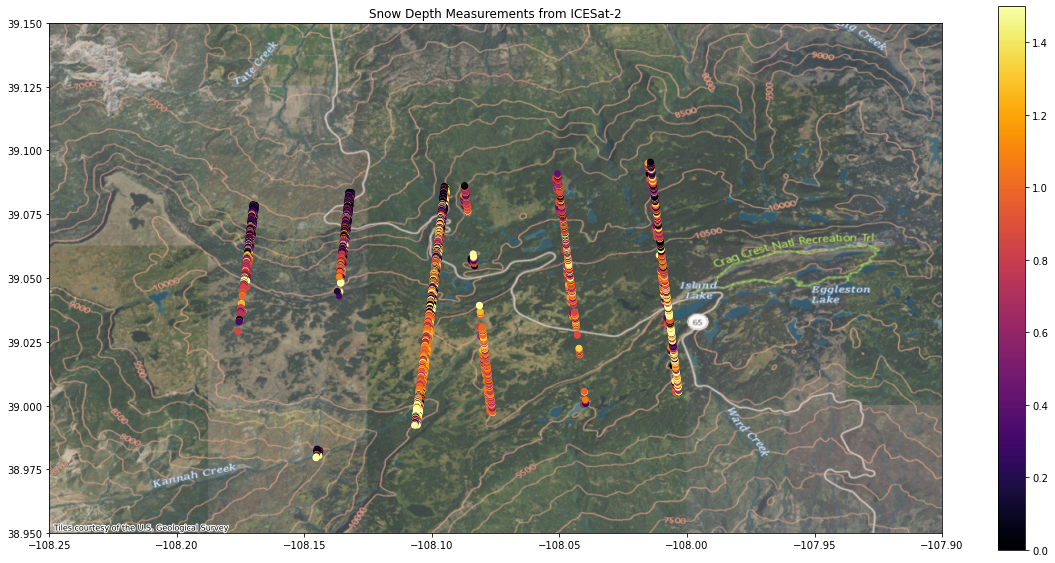

In [220]:
import contextily as cx
import rioxarray as rxa
from os.path import join

# Directory of the uavsar tiffs
data_dir = '/tmp/uavsar-tutorial-data/'
fig, ax = plt.subplots(figsize = (20,10))
img = rxa.open_rasterio(join(data_dir, f'cor.tif'))

# Plot depth measurements
# gdf4.plot(ax = ax, column = 'h_mean', legend = True, cmap = 'inferno')
gdf4.plot(ax = ax, column = 'diff', legend = True, cmap = 'inferno', vmin = 0, vmax = 1.5)

# Set same bounds as uavsar image plot
ax.set_xlim(-108.25,-107.9)
ax.set_ylim(38.95, 39.15)

# Add background map
# cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USTopo)
cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USImageryTopo)
plt.title('Snow Depth Measurements from ICESat-2')
plt.show()

In [157]:
gdf3['distance'][0] - gdf3['distance'][1]

-20.04561369214207

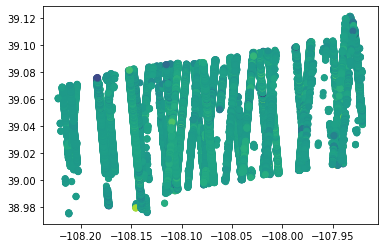

In [109]:
# Now we can plot the results!
f, ax = plt.subplots(figsize = (12,8))

sd_change.plot(ax = ax, cmap = 'Blues', vmin = -10, vmax = 10)

df_both.plot(ax = ax, color = 'black', markersize = 90)
df_both.plot(ax = ax, column = 'sd_diff', legend = True, cmap = 'Blues', vmin = -10, vmax = 10)
ax.scatter(x = snotel_coords[0], y = snotel_coords[1], marker = 'x', color = 'black')
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
ax.set_title('Uavsar Snow Depth Inversion vs Field Observations')

## Uncomment this to zoom in on the measured results
# ax.set_xlim(-108.14, -108.23)
# ax.set_ylim(39, 39.05)

plt.show()
plt.scatter(gdf3["lon"], gdf3["lat"], c = gdf3["diff"])

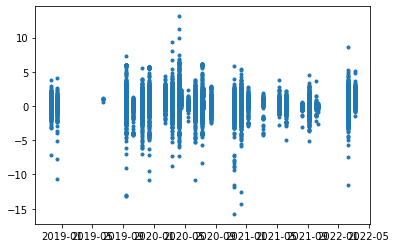

In [37]:
plt.plot(gdf3["diff"], '.')

In [38]:
gdf_off["diff"].mean()

0.06445024387129693

In [39]:
gdf_on["diff"].mean()

0.4616408617333375